In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [2]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [3]:
from keras_preprocessing.sequence import pad_sequences

In [4]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

In [5]:
movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

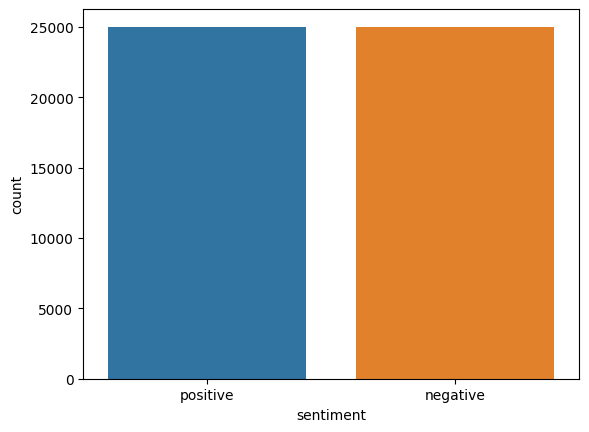

In [8]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [9]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [12]:
def preprocess_text(sen):
    
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
X[3]

'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore '

In [15]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
import io
import json

In [19]:
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [20]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [21]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [23]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
embedding_matrix.shape

(92394, 100)

In [25]:
from keras.layers import Conv1D

In [26]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [27]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [28]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 30s 84ms/step - loss: 0.4655 - acc: 0.7766 - val_loss: 0.3769 - val_acc: 0.8357
Epoch 2/6
250/250 [==============================] - 19s 76ms/step - loss: 0.3416 - acc: 0.8549 - val_loss: 0.3478 - val_acc: 0.8489
Epoch 3/6
250/250 [==============================] - 19s 77ms/step - loss: 0.2868 - acc: 0.8843 - val_loss: 0.3361 - val_acc: 0.8515
Epoch 4/6
250/250 [==============================] - 19s 77ms/step - loss: 0.2419 - acc: 0.9090 - val_loss: 0.3317 - val_acc: 0.8558
Epoch 5/6
250/250 [==============================] - 21s 83ms/step - loss: 0.2033 - acc: 0.9302 - val_loss: 0.3371 - val_acc: 0.8547
Epoch 6/6
250/250 [==============================] - 22s 87ms/step - loss: 0.1663 - acc: 0.9486 - val_loss: 0.3351 - val_acc: 0.8576


In [29]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.3339 - acc: 0.8549


In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33393198251724243
Test Accuracy: 0.8549000024795532


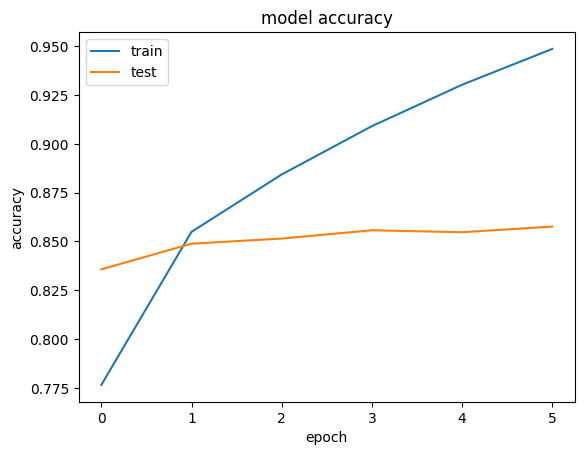

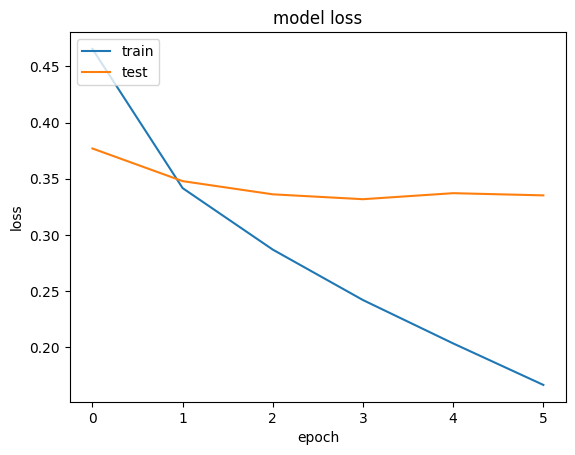

In [31]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [32]:
from keras.layers import LSTM

In [33]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [34]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [35]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/8
250/250 [==============================] - 70s 257ms/step - loss: 0.5184 - acc: 0.7443 - val_loss: 0.4221 - val_acc: 0.8134
Epoch 2/8
250/250 [==============================] - 62s 247ms/step - loss: 0.4287 - acc: 0.8083 - val_loss: 0.3803 - val_acc: 0.8355
Epoch 3/8
250/250 [==============================] - 62s 248ms/step - loss: 0.3761 - acc: 0.8356 - val_loss: 0.3746 - val_acc: 0.8267
Epoch 4/8
250/250 [==============================] - 62s 248ms/step - loss: 0.3470 - acc: 0.8522 - val_loss: 0.3410 - val_acc: 0.8589
Epoch 5/8
250/250 [==============================] - 55s 219ms/step - loss: 0.3249 - acc: 0.8619 - val_loss: 0.3275 - val_acc: 0.8656
Epoch 6/8
250/250 [==============================] - 59s 235ms/step - loss: 0.3029 - acc: 0.8739 - val_loss: 0.3453 - val_acc: 0.8587
Epoch 7/8
250/250 [==============================] - 59s 235ms/step - loss: 0.2844 - acc: 0.8843 - val_loss: 0.3113 - val_acc: 0.8701
Epoch 8/8
250/250 [==============================] - 59s 236ms

In [36]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 13s 40ms/step - loss: 0.3179 - acc: 0.8631


In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3178834617137909
Test Accuracy: 0.863099992275238


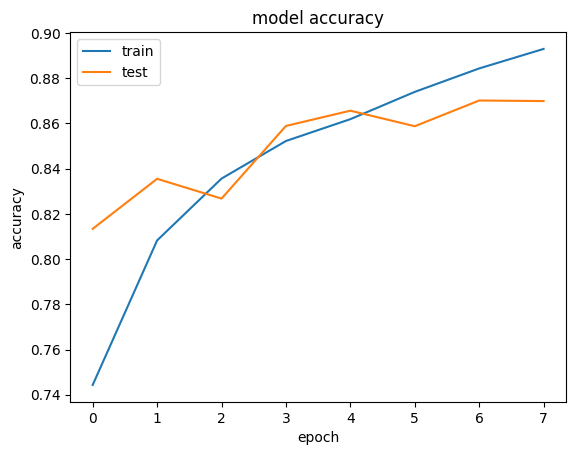

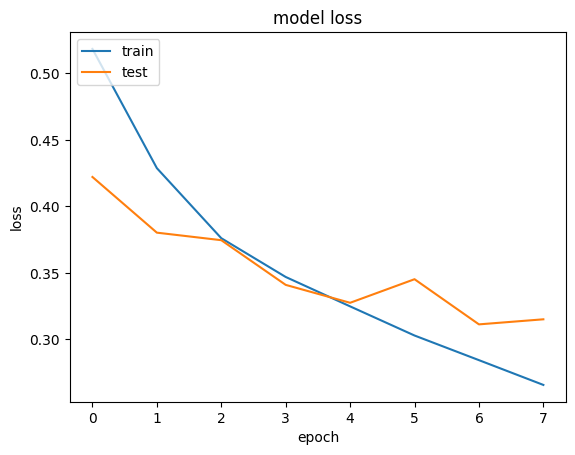

In [38]:

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
pwd

'C:\\Users\\SOWJANYA ANCHULA\\Sentiment_Analysis'

In [41]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [42]:
from keras.models import load_model

model_path ='c1_lstm_model_acc_0.864.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [43]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(8)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3
6,6,Virupaksha,Virupaksha is a well-made horror mystery movie...,7
7,7,ex,I Don't know why other users given it high rat...,4


In [44]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [45]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [46]:
from keras_preprocessing.text import tokenizer_from_json

In [47]:
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [48]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [49]:
unseen_tokenized

[[925,
  1,
  1,
  400,
  14420,
  1289,
  627,
  14035,
  1266,
  7357,
  511,
  1524,
  97,
  1863,
  1370,
  1,
  3416,
  16,
  4,
  25,
  140,
  20211,
  716,
  2161,
  1270,
  14035,
  18,
  12177,
  199,
  659,
  9047,
  76,
  9587,
  1378,
  4780,
  1464,
  6932,
  4780,
  2013,
  7929,
  7741,
  1034,
  33,
  83,
  463,
  435,
  879,
  1740,
  282,
  1469,
  150,
  626,
  3,
  1434,
  1291,
  3,
  62,
  1,
  806,
  4114,
  5415,
  1989,
  191,
  806,
  51,
  854,
  13,
  88,
  11,
  16,
  4012,
  1,
  589,
  1958,
  1398,
  93,
  113,
  1014,
  24,
  270,
  1,
  2759,
  62,
  1014,
  1,
  14035,
  25602,
  25,
  315,
  1064,
  115,
  1852,
  736,
  1,
  14035,
  1776,
  1,
  315,
  3822,
  18,
  383,
  3822,
  569,
  1,
  4051,
  24,
  284,
  164,
  624,
  14035,
  261,
  1,
  12806,
  83,
  5440,
  294,
  1776,
  1,
  1011,
  213,
  278,
  1374,
  1040,
  14943,
  3822,
  897,
  17,
  151,
  312,
  1264,
  1,
  1928,
  285,
  1602,
  14420,
  1,
  3172,
  1,
  122,
  659,
  14

In [50]:
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [51]:
unseen_padded

array([[  879,  1740,   282,  1469,   150,   626,     3,  1434,  1291,
            3,    62,     1,   806,  4114,  5415,  1989,   191,   806,
           51,   854,    13,    88,    11,    16,  4012,     1,   589,
         1958,  1398,    93,   113,  1014,    24,   270,     1,  2759,
           62,  1014,     1, 14035, 25602,    25,   315,  1064,   115,
         1852,   736,     1, 14035,  1776,     1,   315,  3822,    18,
          383,  3822,   569,     1,  4051,    24,   284,   164,   624,
        14035,   261,     1, 12806,    83,  5440,   294,  1776,     1,
         1011,   213,   278,  1374,  1040, 14943,  3822,   897,    17,
          151,   312,  1264,     1,  1928,   285,  1602, 14420,     1,
         3172,     1,   122,   659,   140, 13082,  1645, 10209,  1615,
          937],
       [  121,   234,   352,  8844,  6752,   630,    20,  6507,    72,
         1400,  6730,  2885, 24074, 10547,  3633,  1645,    25, 11701,
         1335, 19425,    26,   281,  1574,  1143,   288, 1370

In [52]:
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 1s/step


array([[0.9038752 ],
       [0.9954781 ],
       [0.18124136],
       [0.5725045 ],
       [0.9639319 ],
       [0.03909373],
       [0.9009869 ],
       [0.03047224]], dtype=float32)

In [53]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(8)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.0
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.8
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,5.7
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.6
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4
6,Virupaksha,Virupaksha is a well-made horror mystery movie...,7,9.0
7,ex,I Don't know why other users given it high rat...,4,0.3


In [54]:
unseen_sentiments


array([[0.9038752 ],
       [0.9954781 ],
       [0.18124136],
       [0.5725045 ],
       [0.9639319 ],
       [0.03909373],
       [0.9009869 ],
       [0.03047224]], dtype=float32)

In [ ]:
unseen_sentiments[6][0]

In [56]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[7][0]*10,1)}"

In [57]:
prediction_text

'Positive Review with probable IMDb rating as: 0.3'

In [58]:
import joblib
joblib.dump(pipeline,'sentiment_analysis.pkl')

NameError: name 'pipeline' is not defined